## Quick info !

Transfer learning is a process where you take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs

## Import relevant Libraries 

In [1]:
# Basic imports
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow imports  
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

## ToDo List 

-Download and explore flower dataset.<br>
-Reformat images and create batches.<br>
-Apply transfer Learning with TensorFlow_Hub.<br>
-Plot Training & Validation Graphs. <br>
-Check predictions.<br>
-Plot model predictions.<br>
-Repeat process but this time with the inception model.

## Download Flower data set 

In [2]:
# The code below allows us to download and split the data at the same time 
# Our data set is 

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

## Print info about the data set 

-This gives us information about the number of classes.<br>
-The number of images in training_set.<br>
-The number of images in validation_ser.

In [3]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



The output we obtain below shows that all the images are not of the same shape.

In [4]:
# This code helps as to print the shape of the first 5 images in training set
# enumerate is an easy way of iterating through the data set
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


## Reformat Images and Create Batches 

-MobileNet will be expecting an image resolution of (224,224).<br>
-We need to craete a function that will convert all our images.

In [5]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Simple Transfer Learning 

- To apply this technique , we need to create a feature extractor using a feature vector (MobileNet) from tensorflow hub

In [6]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

## Freeze the Pre-Trained Model 

In [7]:
# we freeze all the variables in feature extractor layer so the training ,
# only modifies the final classification layer.
feature_extractor.trainable = False

## Attach a classification layer 

In [8]:
# we simply add an additionanl final classification layer with an output of 5
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model 

In [9]:
# Compile the model first
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 147s 2s/step - loss: 0.7494 - accuracy: 0.7306 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/6
81/81 [==============================] - 81s 999ms/step - loss: 0.3789 - accuracy: 0.8750 - val_loss: 0.3396 - val_accuracy: 0.8883
Epoch 3/6
81/81 [==============================] - 80s 993ms/step - loss: 0.2972 - accuracy: 0.9070 - val_loss: 0.3079 - val_accuracy: 0.8901
Epoch 4/6
81/81 [==============================] - 81s 995ms/step - loss: 0.2523 - accuracy: 0.9284 - val_loss: 0.2847 - val_accuracy: 0.9028
Epoch 5/6
81/81 [==============================] - 79s 981ms/step - loss: 0.2090 - accuracy: 0.9393 - val_loss: 0.2754 - val_accuracy: 0.9146
Epoch 6/6
81/81 [==============================] - 111s 1s/step - loss: 0.1853 - accuracy: 0.9521 - val_loss: 0.2693 - val_accuracy: 0.9101


## Plot Training and Validation Graphs

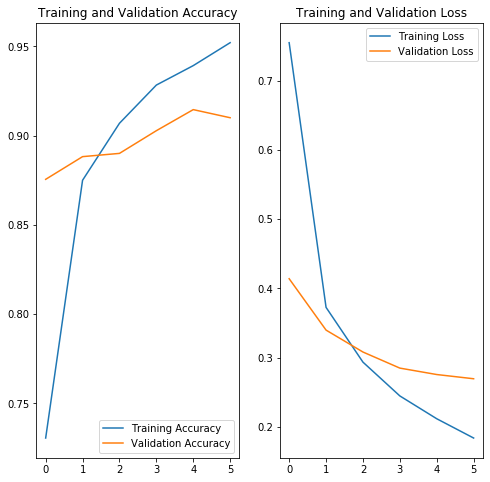

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Check Predictions 

In [11]:
# we first need to get the names for each class

class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


## Create an Image Batch and Make Predictions


In [13]:
#We use the next() function to manually iterate through all the items of an iterator.
#get an iterator using iter()
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy() # Squeeze removes dimensions of size 1 from the shape of a tensor

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['roses' 'tulips' 'dandelion' 'roses' 'tulips' 'dandelion' 'roses'
 'sunflowers' 'sunflowers' 'sunflowers' 'roses' 'tulips' 'dandelion'
 'dandelion' 'roses' 'sunflowers' 'dandelion' 'dandelion' 'dandelion'
 'sunflowers' 'sunflowers' 'sunflowers' 'sunflowers' 'roses' 'dandelion'
 'tulips' 'roses' 'daisy' 'dandelion' 'daisy' 'dandelion' 'daisy']


## Print True Labels and Predicted Indices 

In [15]:
#We can see that our model did really well in predicting the images
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [4 2 0 4 2 0 4 3 0 3 4 2 0 0 4 3 0 0 0 3 3 3 3 4 0 2 4 1 0 1 0 1]
Predicted labels:  [4 2 0 4 2 0 4 3 3 3 4 2 0 0 4 3 0 0 0 3 3 3 3 4 0 2 4 1 0 1 0 1]


## Finally, we plot Model Predictions 

As we can see below, we had only one incorrect prediction 

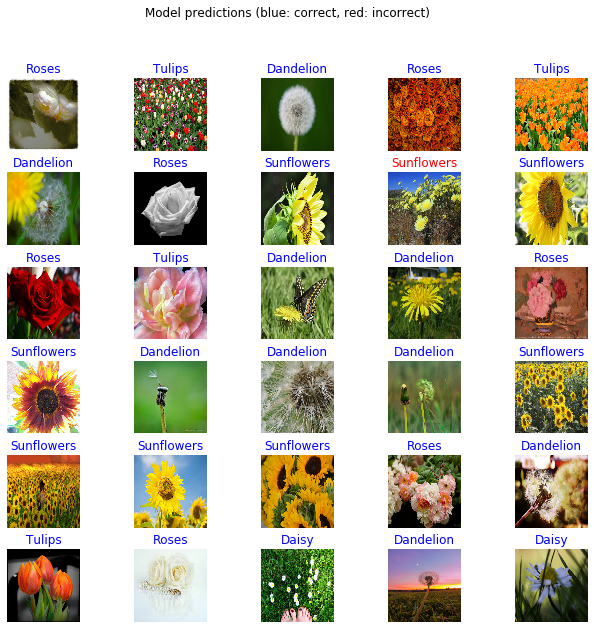

In [23]:
plt.figure(figsize=(11,10))
for n in range(30):
  plt.subplot(6,5,n+1) # (row,column)
  plt.subplots_adjust(hspace = 0.3) # adjusts the size and space between images
  plt.imshow(image_batch[n]) # iterates through range and shows each images
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")